## Lets Import all the Relevant libraries

In [1]:
import pandas as pd
import matplotlib

### Set the Data Location to a variable

In [2]:
RAW_DATA = "../data/raw/"

# Initial Analysis

### Read the dataset into a pandas dataframe for further analysis

In [3]:
raw_df = pd.read_parquet(F"{RAW_DATA}/data.parquet.gzip", engine="fastparquet")
raw_df.head()

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount
0,2020-05-20 15:43:38.364972+00:00,China,2020-04-19 00:00:00+00:00,2020-04-18 00:00:00+00:00,0.0,5720.0
1,2020-05-20 15:43:47.914346+00:00,China,2020-04-19 00:00:00+00:00,2020-04-13 00:00:00+00:00,1.0,8800.0
2,2020-05-20 15:36:56.866239+00:00,China,2020-04-19 00:00:00+00:00,2020-04-15 00:00:00+00:00,0.0,1760.0
3,2020-05-20 15:00:33.694108+00:00,China,2020-04-19 00:00:00+00:00,2020-04-13 00:00:00+00:00,,1760.0
4,2020-05-20 15:43:18.521402+00:00,China,2020-04-19 00:00:00+00:00,2020-04-14 00:00:00+00:00,3.0,8800.0


### Lets check some info into our dataset to get a better idea

In [4]:
# Check the shape of the dataset we are dealing with

raw_df.shape

(511427, 6)

So we have `511427` records with `6` columns 

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511427 entries, 0 to 511426
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       511427 non-null  object             
 1   country_code    511427 non-null  object             
 2   last_order_ts   511427 non-null  object             
 3   first_order_ts  511427 non-null  datetime64[ns, UTC]
 4   total_orders    511427 non-null  object             
 5   voucher_amount  481860 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 23.4+ MB


**As we can see above most of the fields are object types, with only `first_order_ts` as datetime and voucher_amount as `float`**.
1) We would require to convert `last_order_ts` and `timestamp` fields to `datetime` type
2) Standardize the `datetime` format for consistency accross the dataset
3) There seems to be some issue with `voucher_amount` fields as the `non-null` count in this field seems to be lesser than others. Will need to check that

### Lets get an idea of the country wise distribution to get an idea

In [6]:
raw_df['country_code'].value_counts()

China        169722
Australia    134004
Peru         106547
Latvia       101154
Name: country_code, dtype: int64

<AxesSubplot:>

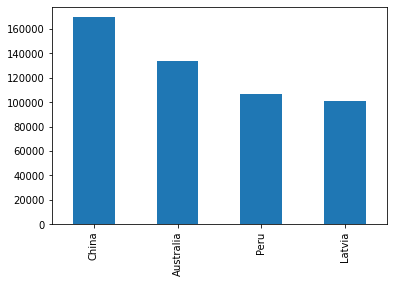

In [7]:
raw_df["country_code"].value_counts().plot(kind="bar")

As seen above, we have substantial amount of data for `China`, `Australia` and `Latvia`. Since we are only interested in `Peru`, it is always a good idea to filter the datasets for `Peru` on data processing.  But for now lets analyze and clean the entire dataset

## Data Cleaning

In this step, we will perform following activities:
* Deal with `NaN` and `missing` values in the dataset. Especially we need to check the `voucher_amount` column as it seems to have some sort of issue.
* Convert timestamp field types from `Object` to `Timestamp`.
* Standardize the `Timestamp` format in all the fields.
* Deduplicate Records
* Check logically invalid records (`last_order_ts` should be greater than or equal to `first_order_ts`)


### Missing and NaN values 

Lets first check if for all fields if we have any `None` or empty string values `''` 

In [8]:
raw_df.apply(lambda x: (x is None) or (x == '')).sum()

timestamp             0
country_code          0
last_order_ts         0
first_order_ts        0
total_orders      40914
voucher_amount        0
dtype: int64

Except for `total_orders` all other fields doesnt seem to have any `None` or empty string values in them. So lets proceed with data cleaning and type conversions

Lets start with Timestamp fields

In [9]:
# raw_df[raw_df["last_order_ts"].isna()].count()
raw_df.apply(lambda x: (x is None) or (x == '')).sum()

timestamp             0
country_code          0
last_order_ts         0
first_order_ts        0
total_orders      40914
voucher_amount        0
dtype: int64

In [10]:
raw_df[raw_df["timestamp"].isna()].count()

timestamp         0
country_code      0
last_order_ts     0
first_order_ts    0
total_orders      0
voucher_amount    0
dtype: int64

In [11]:
raw_df[raw_df["first_order_ts"].isna()].count()

timestamp         0
country_code      0
last_order_ts     0
first_order_ts    0
total_orders      0
voucher_amount    0
dtype: int64

As checked above, its now safe to convert the Object types to Timestamp as none of the timestamp fields have missing values

In [12]:
timestamp_fields = ['timestamp', 'first_order_ts', 'last_order_ts']

for field in timestamp_fields:
    raw_df[field] = pd.to_datetime(raw_df[field])

In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511427 entries, 0 to 511426
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       511427 non-null  datetime64[ns, UTC]
 1   country_code    511427 non-null  object             
 2   last_order_ts   511427 non-null  datetime64[ns, UTC]
 3   first_order_ts  511427 non-null  datetime64[ns, UTC]
 4   total_orders    511427 non-null  object             
 5   voucher_amount  481860 non-null  float64            
dtypes: datetime64[ns, UTC](3), float64(1), object(2)
memory usage: 23.4+ MB


Now Lets look at `country_code` and `total_orders`

Total orders seems to be an `integer` field as `float` doesnt make sense for an order count and hence we will convert the missing values with `0` and convert it to `int` type

As we saw earlier, `total_order` field had some invalid data in them as `None` or `''`. So replace them with `0.0` first as I was unable to directly cast this field to `int` type. So we will first convert them to `float` and then to `int`

In [14]:
raw_df[raw_df["country_code"].isna()].count()

# Country code seems to be clean

timestamp         0
country_code      0
last_order_ts     0
first_order_ts    0
total_orders      0
voucher_amount    0
dtype: int64

In [15]:
# Before conversion we need to check for NaN as well

raw_df[raw_df["total_orders"].isna()].count()

timestamp         0
country_code      0
last_order_ts     0
first_order_ts    0
total_orders      0
voucher_amount    0
dtype: int64

Lets convert to integer and replace all empty strings to default of `0`

In [16]:
#First lets check if we are able to convert the float to integer without any data rounding issues etc

is_float = raw_df['total_orders'].apply(lambda x: float(x or '0.0').is_integer())

raw_df[is_float].count()

#There seems to be no data loss issues 

timestamp         511427
country_code      511427
last_order_ts     511427
first_order_ts    511427
total_orders      511427
voucher_amount    481860
dtype: int64

In [17]:
# So we dont have any data issues on conversion from float to int. So we proceed with this

raw_df['total_orders'] = raw_df['total_orders'].apply(lambda x: int(float(x or '0.0')))
raw_df.count()



timestamp         511427
country_code      511427
last_order_ts     511427
first_order_ts    511427
total_orders      511427
voucher_amount    481860
dtype: int64

In [18]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511427 entries, 0 to 511426
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       511427 non-null  datetime64[ns, UTC]
 1   country_code    511427 non-null  object             
 2   last_order_ts   511427 non-null  datetime64[ns, UTC]
 3   first_order_ts  511427 non-null  datetime64[ns, UTC]
 4   total_orders    511427 non-null  int64              
 5   voucher_amount  481860 non-null  float64            
dtypes: datetime64[ns, UTC](3), float64(1), int64(1), object(1)
memory usage: 23.4+ MB


Lets now check the `voucher_amount` field discrepency 

In [19]:
#Check for Nan or missing values

raw_df[raw_df["voucher_amount"].isna()].count()

timestamp         29567
country_code      29567
last_order_ts     29567
first_order_ts    29567
total_orders      29567
voucher_amount        0
dtype: int64

Above check clearly justifies the difference of `29567`. So lets replace it with default 0 

In [20]:
raw_df["voucher_amount"] = raw_df["voucher_amount"].fillna(0)
display(raw_df.head())

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount
0,2020-05-20 15:43:38.364972+00:00,China,2020-04-19 00:00:00+00:00,2020-04-18 00:00:00+00:00,0,5720.0
1,2020-05-20 15:43:47.914346+00:00,China,2020-04-19 00:00:00+00:00,2020-04-13 00:00:00+00:00,1,8800.0
2,2020-05-20 15:36:56.866239+00:00,China,2020-04-19 00:00:00+00:00,2020-04-15 00:00:00+00:00,0,1760.0
3,2020-05-20 15:00:33.694108+00:00,China,2020-04-19 00:00:00+00:00,2020-04-13 00:00:00+00:00,0,1760.0
4,2020-05-20 15:43:18.521402+00:00,China,2020-04-19 00:00:00+00:00,2020-04-14 00:00:00+00:00,3,8800.0


In [21]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511427 entries, 0 to 511426
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       511427 non-null  datetime64[ns, UTC]
 1   country_code    511427 non-null  object             
 2   last_order_ts   511427 non-null  datetime64[ns, UTC]
 3   first_order_ts  511427 non-null  datetime64[ns, UTC]
 4   total_orders    511427 non-null  int64              
 5   voucher_amount  511427 non-null  float64            
dtypes: datetime64[ns, UTC](3), float64(1), int64(1), object(1)
memory usage: 23.4+ MB


Now it seems to be converted properly to appropriate data types, without any data loss

Lets try to convert `voucher_amount` field to integer if possible, as float values can result in issues with precision values a lot of times

In [22]:
#First lets check if we are able to convert the float to integer without any data rounding issues etc

is_float = raw_df['voucher_amount'].apply(lambda x: float(x or '0.0').is_integer())

raw_df[is_float].count()

timestamp         511427
country_code      511427
last_order_ts     511427
first_order_ts    511427
total_orders      511427
voucher_amount    511427
dtype: int64

In [23]:
# There doesn't seem to have any issue with rounding etc for conversion. So lets convert
raw_df['voucher_amount'] = raw_df['voucher_amount'].apply(lambda x: int(float(x)))
display(raw_df)

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount
0,2020-05-20 15:43:38.364972+00:00,China,2020-04-19 00:00:00+00:00,2020-04-18 00:00:00+00:00,0,5720
1,2020-05-20 15:43:47.914346+00:00,China,2020-04-19 00:00:00+00:00,2020-04-13 00:00:00+00:00,1,8800
2,2020-05-20 15:36:56.866239+00:00,China,2020-04-19 00:00:00+00:00,2020-04-15 00:00:00+00:00,0,1760
3,2020-05-20 15:00:33.694108+00:00,China,2020-04-19 00:00:00+00:00,2020-04-13 00:00:00+00:00,0,1760
4,2020-05-20 15:43:18.521402+00:00,China,2020-04-19 00:00:00+00:00,2020-04-14 00:00:00+00:00,3,8800
...,...,...,...,...,...,...
511422,2020-04-03 18:31:36.635072+00:00,Latvia,2020-01-04 00:00:00+00:00,2019-10-30 00:00:00+00:00,27,4400
511423,2020-04-03 18:33:32.365196+00:00,Latvia,2020-01-04 00:00:00+00:00,2019-08-29 00:00:00+00:00,10,4400
511424,2020-04-03 19:23:07.711424+00:00,Peru,2020-01-04 00:00:00+00:00,2019-10-14 00:00:00+00:00,47,4400
511425,2020-04-03 19:19:06.162203+00:00,Australia,2020-01-04 00:00:00+00:00,2019-09-24 00:00:00+00:00,2,11000


In [24]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511427 entries, 0 to 511426
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       511427 non-null  datetime64[ns, UTC]
 1   country_code    511427 non-null  object             
 2   last_order_ts   511427 non-null  datetime64[ns, UTC]
 3   first_order_ts  511427 non-null  datetime64[ns, UTC]
 4   total_orders    511427 non-null  int64              
 5   voucher_amount  511427 non-null  int64              
dtypes: datetime64[ns, UTC](3), int64(2), object(1)
memory usage: 23.4+ MB


## Lets check for Duplicate Records

In [25]:
is_duplicate = raw_df.duplicated(keep=False)

display(raw_df[is_duplicate])

,timestamp,country_code,last_order_ts,first_order_ts,total_orders,voucher_amount
80534,2020-03-04 15:43:49.555721+00:00,China,2020-02-03 00:00:00+00:00,2019-01-24 00:00:00+00:00,21,8800
80544,2020-03-04 15:43:49.555721+00:00,China,2020-02-03 00:00:00+00:00,2019-01-24 00:00:00+00:00,21,8800
91323,2020-02-29 17:38:13.247885+00:00,Latvia,2019-11-30 00:00:00+00:00,2019-11-29 00:00:00+00:00,0,1540
91330,2020-02-29 17:38:13.247885+00:00,Latvia,2019-11-30 00:00:00+00:00,2019-11-29 00:00:00+00:00,0,1540
246897,2020-03-22 20:00:51.972777+00:00,China,2019-12-21 00:00:00+00:00,2019-12-21 00:00:00+00:00,136,5720
246904,2020-03-22 20:00:51.972777+00:00,China,2019-12-21 00:00:00+00:00,2019-12-21 00:00:00+00:00,136,5720
247234,2020-03-22 18:51:40.516382+00:00,Latvia,2019-12-21 00:00:00+00:00,2019-05-01 00:00:00+00:00,0,13200
247308,2020-03-22 18:51:40.516382+00:00,Latvia,2019-12-21 00:00:00+00:00,2019-05-01 00:00:00+00:00,0,13200
248302,2020-03-22 20:15:54.378140+00:00,Latvia,2019-12-21 00:00:00+00:00,2019-12-21 00:00:00+00:00,136,4400
248312,2020-03-22 20:15:54.514202+00:00,Latvia,2019-12-21 00:00:00+00:00,2019-12-21 00:00:00+00:00,136,4400


So we have 12 Duplicate records in our dataset. Lets remove it and complete the data cleansing

In [26]:
# We have total of 24 records. We will keep first record and remove others

processed_df = raw_df.drop_duplicates(inplace=False)

In [27]:
processed_df.duplicated().sum()

0

# Cleaned DF

In [28]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511415 entries, 0 to 511426
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       511415 non-null  datetime64[ns, UTC]
 1   country_code    511415 non-null  object             
 2   last_order_ts   511415 non-null  datetime64[ns, UTC]
 3   first_order_ts  511415 non-null  datetime64[ns, UTC]
 4   total_orders    511415 non-null  int64              
 5   voucher_amount  511415 non-null  int64              
dtypes: datetime64[ns, UTC](3), int64(2), object(1)
memory usage: 27.3+ MB


### Check if valid value

`Last Order Timestamp` cannot be before `First Order Timestamp`. So lets check for this condition and remove any invalid records

In [29]:
is_wrong = processed_df["last_order_ts"] < processed_df["first_order_ts"]

processed_df[is_wrong].count()

timestamp         0
country_code      0
last_order_ts     0
first_order_ts    0
total_orders      0
voucher_amount    0
dtype: int64

In [30]:
processed_df.to_csv("../data/processed/clean_data.csv", encoding="UTF-8", index=False)

# Summary

Data had following issue identified:

* Empty string values in `total_order` column and was of Object Type
* Timestamp fields like `last_order_ts` and `timestamp` where of Object type
* Duplicate records found : 24
* `Nan` values in `voucher_amount` field

Exploratory Resolution Applied:
* Empty string values in `total_order` field replaced with `0` and converted to `int` from `object`
* All timestamp fields converted to `datetime64[ns, UTC]` datetime format 
* Deduplicated the records and kept the first occurence
* `voucher_amount` field converted from `object` to `int` and replaced `NaN` with `0`